In [1]:
#imports
import os
import cv2
import torch
import random
import zipfile
import numpy as np
import torch.nn as nn
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.optim as optim
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
import torchvision
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import ToTensor
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

In [4]:
!pip install "deeplake<4"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.2/640.2 kB 31.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3transfer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 130.3 MB/s eta 0:00:00
   ━

In [5]:
import deeplake
df_train = deeplake.load("hub://activeloop/carpk-train", read_only=True)

/usr/local/lib/python3.11/dist-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.2.1) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(
-

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/carpk-train



/

hub://activeloop/carpk-train loaded successfully.



In [6]:
import deeplake
df_test = deeplake.load("hub://activeloop/carpk-test", read_only=True)

\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/carpk-test



/

hub://activeloop/carpk-test loaded successfully.



In [7]:
# Assuming 'images' and 'labels' exist as tensors in the dataset
images_train = df_train['images']
labels_train = df_train['labels']

print(images_train.shape)  # Prints the shape of the images tensor
print(labels_train.shape)

(989, 720, 1280, 3)
(989, None)


In [8]:
print(df_train.tensors)
print(df_test.tensors)

{'images': Tensor(key='images'), 'boxes': Tensor(key='boxes'), 'labels': Tensor(key='labels')}
{'images': Tensor(key='images'), 'boxes': Tensor(key='boxes'), 'labels': Tensor(key='labels')}


In [9]:
bounding_boxes_train = df_train['boxes'][0].numpy()
bounding_boxes_test = df_test['boxes'][0].numpy()
print(bounding_boxes_train)

[[766. 133.  38.  84.]
 [766. 228.  35.  83.]
 [758. 358.  35.  81.]
 [750. 467.  36.  62.]
 [755. 534.  34.  79.]
 [542. 387.  77.  40.]
 [555. 433.  73.  35.]
 [553. 473.  77.  36.]
 [544. 513.  75.  35.]
 [542. 552.  70.  36.]
 [530. 593.  79.  35.]
 [543. 630.  68.  38.]
 [559. 671.  60.  35.]
 [459. 330.  75.  41.]
 [344. 183.  75.  42.]
 [233. 215.  77.  47.]
 [233. 258.  82.  52.]
 [234. 301.  71.  58.]
 [220. 343.  75.  52.]
 [221. 391.  75.  58.]
 [213. 440.  82.  50.]
 [218. 487.  77.  49.]
 [217. 530.  84.  52.]
 [208. 575.  85.  53.]
 [216. 625.  80.  50.]
 [214. 671.  75.  46.]
 [388. 419.  75.  49.]
 [390. 466.  68.  45.]
 [367. 509.  76.  46.]
 [375. 551.  72.  43.]
 [373. 664.  73.  46.]]


In [10]:
print(bounding_boxes_test)

[[ 766.  653.   73.   37.]
 [ 572.  567.   77.   32.]
 [ 304.  695.   78.   24.]
 [ 569.  526.   79.   36.]
 [ 293.  612.   77.   38.]
 [ 300.  577.   70.   33.]
 [ 851.  567.   77.   33.]
 [ 849.  607.   79.   35.]
 [ 852.  649.   66.   35.]
 [ 763.  530.   72.   36.]
 [ 247.  554.   35.   75.]
 [ 255.  641.   31.   72.]
 [ 299.  537.   72.   31.]
 [ 292.  494.   75.   37.]
 [ 290.  454.   69.   36.]
 [ 292.  418.   70.   33.]
 [ 469.  368.   75.   38.]
 [ 568.  367.   71.   36.]
 [ 567.  407.   69.   32.]
 [ 471.  408.   76.   40.]
 [ 478.  449.   69.   34.]
 [ 565.  443.   81.   37.]
 [ 293.  655.   78.   30.]
 [ 758.  450.   74.   36.]
 [ 761.  487.   71.   34.]
 [ 474.  530.   82.   35.]
 [ 575.  688.   67.   31.]
 [ 480.  691.   87.   28.]
 [ 478.  647.   82.   38.]
 [ 563.  650.   82.   36.]
 [ 567.  605.   82.   37.]
 [ 476.  611.   76.   34.]
 [ 488.  568.   67.   36.]
 [ 570.  488.   77.   35.]
 [ 487.  494.   70.   33.]
 [ 843.  409.   75.   35.]
 [ 841.  450.   79.   36.]
 

In [12]:
for i in range(3):  # Check first 3 samples
    boxes = df_train['boxes'][i].numpy()
    labels = df_train['labels'][i].numpy()
    print(f"Sample {i}:")
    print("  Boxes:", boxes)
    print("  Labels:", labels)

Sample 0:
  Boxes: [[766. 133.  38.  84.]
 [766. 228.  35.  83.]
 [758. 358.  35.  81.]
 [750. 467.  36.  62.]
 [755. 534.  34.  79.]
 [542. 387.  77.  40.]
 [555. 433.  73.  35.]
 [553. 473.  77.  36.]
 [544. 513.  75.  35.]
 [542. 552.  70.  36.]
 [530. 593.  79.  35.]
 [543. 630.  68.  38.]
 [559. 671.  60.  35.]
 [459. 330.  75.  41.]
 [344. 183.  75.  42.]
 [233. 215.  77.  47.]
 [233. 258.  82.  52.]
 [234. 301.  71.  58.]
 [220. 343.  75.  52.]
 [221. 391.  75.  58.]
 [213. 440.  82.  50.]
 [218. 487.  77.  49.]
 [217. 530.  84.  52.]
 [208. 575.  85.  53.]
 [216. 625.  80.  50.]
 [214. 671.  75.  46.]
 [388. 419.  75.  49.]
 [390. 466.  68.  45.]
 [367. 509.  76.  46.]
 [375. 551.  72.  43.]
 [373. 664.  73.  46.]]
  Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Sample 1:
  Boxes: [[ 780.  619.   91.   81.]
 [ 888.  676.   57.   43.]
 [ 952.  658.   54.   61.]
 [1009.  653.   55.   66.]
 [1059.  639.   67.   80.]
 [1115.  641.   66.   78.]
 [1171.  619

In [13]:
def convert_boxes_xywh_to_xyxy(boxes):
    boxes = boxes.copy()
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max = x_min + width
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max = y_min + height
    return boxes

In [14]:
boxes_train_xywh = df_train['boxes'][0].numpy()
boxes_train_xyxy = convert_boxes_xywh_to_xyxy(boxes_train_xywh)

print(boxes_train_xyxy[0])

boxes_test_xywh = df_test['boxes'][0].numpy()
boxes_test_xyxy = convert_boxes_xywh_to_xyxy(boxes_test_xywh)

print(boxes_test_xyxy[0])

[766. 133. 804. 217.]
[766. 653. 839. 690.]


In [15]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class CustomObjectDetectionDataset(Dataset):
    def __init__(self, images, boxes, labels, transform=None):
        """
        Args:
            images (list): List of image paths or image objects.
            boxes (list): List of [x_min, y_min, width, height] arrays per image.
            labels (list): List of label arrays per image.
            transform (callable, optional): Optional transform to apply to image and target.
        """
        self.images = images
        self.boxes = boxes
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def convert_boxes_xywh_to_xyxy(self, boxes):
        """Convert [x_min, y_min, width, height] to [x_min, y_min, x_max, y_max]."""
        boxes = boxes.copy()
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]  # x_max
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]  # y_max
        return boxes

    def __getitem__(self, idx):
    # Load image (from path or tensor)
      image = self.images[idx]
      if isinstance(image, str):  # if it's a path
        image = Image.open(image).convert("RGB")
      else:
        image = Image.fromarray(image)

        # Get and convert boxes
        boxes = self.convert_boxes_xywh_to_xyxy(self.boxes[idx])
        boxes = torch.tensor(boxes, dtype=torch.float32)

        # Labels
        labels = torch.tensor(self.labels[idx], dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        # Apply transforms
        if self.transform:
            image, target = self.transform(image, target)

        return image, target


In [16]:
train_images = [df_train['images'][i].numpy() for i in range(len(df_train))]
train_boxes = [df_train['boxes'][i].numpy() for i in range(len(df_train))]
train_labels = [df_train['labels'][i].numpy() for i in range(len(df_train))]

/usr/local/lib/python3.11/dist-packages/deeplake/core/tensor.py:719: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


In [17]:
test_images = [df_test['images'][i].numpy() for i in range(len(df_test))]
test_boxes = [df_test['boxes'][i].numpy() for i in range(len(df_test))]
test_labels = [df_test['labels'][i].numpy() for i in range(len(df_test))]

In [18]:
import torchvision.transforms.functional as F
from torchvision.transforms import ColorJitter
import random
import math
import torch

class SimpleObjectDetectionTransform:
    def __init__(self, image_size=(128, 128), augment=True):
        self.image_size = image_size
        self.augment = augment
        self.jitter = ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        self.to_tensor = ToTensor()
    def __call__(self, image, target):
        orig_w, orig_h = image.size

        # Resize image
        image = F.resize(image, self.image_size)

        # Scale boxes
        boxes = target['boxes']
        scale_x = self.image_size[0] / orig_w
        scale_y = self.image_size[1] / orig_h
        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

        # Horizontal flip
        if self.augment and random.random() > 0.5:
            image = F.hflip(image)
            boxes[:, [0, 2]] = self.image_size[0] - boxes[:, [2, 0]]

        # Rotation
        if self.augment and random.random() > 0.5:
            angle = random.uniform(-15, 15)
            image = F.rotate(image, angle)

            cx, cy = self.image_size[0] / 2, self.image_size[1] / 2
            for i in range(boxes.shape[0]):
                x1, y1, x2, y2 = boxes[i]
                corners = torch.tensor([
                    [x1, y1],
                    [x2, y1],
                    [x2, y2],
                    [x1, y2]
                ])
                angle_rad = -math.radians(angle)
                rot_mat = torch.tensor([
                    [math.cos(angle_rad), -math.sin(angle_rad)],
                    [math.sin(angle_rad),  math.cos(angle_rad)]
                ])
                rotated = (corners - torch.tensor([cx, cy])) @ rot_mat.T + torch.tensor([cx, cy])
                x_coords, y_coords = rotated[:, 0], rotated[:, 1]
                boxes[i] = torch.tensor([x_coords.min(), y_coords.min(), x_coords.max(), y_coords.max()])

        # Color jitter
        if self.augment:
            image = self.jitter(image)

        image = self.to_tensor(image)

        # Return both the image and the target
        return image, target


In [19]:
train_transform = SimpleObjectDetectionTransform(image_size=(224, 224), augment=True)
test_transform = SimpleObjectDetectionTransform(image_size=(224, 224), augment=False)


In [20]:
train_dataset = CustomObjectDetectionDataset(
    images=train_images,
    boxes=train_boxes,
    labels=train_labels,
    transform=train_transform
)

test_dataset = CustomObjectDetectionDataset(
    images=test_images,
    boxes=test_boxes,
    labels=test_labels,
    transform=test_transform
)

In [21]:
from torch.utils.data import DataLoader

# to handle bounding boxes)
def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images, 0)
    return images, targets

# Create DataLoader for training
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

# for testing
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [22]:
import torchvision
import torch

# Load Faster R-CNN with a ResNet backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 177MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
import time
import matplotlib.pyplot as plt

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    losses = []
    header = f'Epoch: [{epoch}]'

    for i, (images, targets) in enumerate(data_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # gradients all zero
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss
        total_loss = sum(loss for loss in loss_dict.values())

        # Backprop
        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())  # Track the loss

        if i % print_freq == 0:
            print(f'{header} Step [{i}/{len(data_loader)}] Loss: {total_loss.item()}')

    avg_loss = sum(losses) / len(losses)  # Average loss for epoch
    return avg_loss

def train(model, train_loader, num_epochs=10):
    epoch_losses = []
    for epoch in range(num_epochs):
        start_time = time.time()
        avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        epoch_losses.append(avg_loss)
        print(f'Epoch {epoch+1} completed in {time.time()-start_time:.2f}s. Avg Loss: {avg_loss:.4f}')

    return epoch_losses

# Train
losses = train(model, train_loader, num_epochs=10)


Epoch: [0] Step [0/124] Loss: 2.357808828353882
Epoch: [0] Step [10/124] Loss: 1.7076976299285889
Epoch: [0] Step [20/124] Loss: 0.6264691948890686
Epoch: [0] Step [30/124] Loss: 0.6256248950958252
Epoch: [0] Step [40/124] Loss: 0.6753765344619751
Epoch: [0] Step [50/124] Loss: 0.7113412022590637
Epoch: [0] Step [60/124] Loss: 0.6018939018249512
Epoch: [0] Step [70/124] Loss: 0.5611733198165894
Epoch: [0] Step [80/124] Loss: 0.6554031372070312
Epoch: [0] Step [90/124] Loss: 0.5182149410247803
Epoch: [0] Step [100/124] Loss: 0.8241592049598694
Epoch: [0] Step [110/124] Loss: 0.6099467873573303
Epoch: [0] Step [120/124] Loss: 0.44900667667388916
Epoch 1 completed in 195.81s. Avg Loss: 4.4060
Epoch: [1] Step [0/124] Loss: 0.49704962968826294
Epoch: [1] Step [10/124] Loss: 0.3955904245376587
Epoch: [1] Step [20/124] Loss: 0.3427191376686096
Epoch: [1] Step [30/124] Loss: 0.4613223969936371
Epoch: [1] Step [40/124] Loss: 0.321682870388031
Epoch: [1] Step [50/124] Loss: 0.3744491934776306
Ep

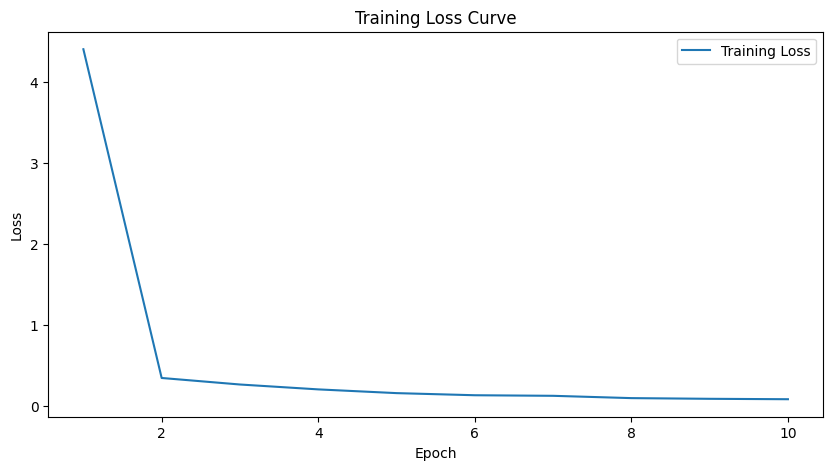

In [24]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(losses) + 1), losses, label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

In [25]:
def train(model, train_loader, test_loader, num_epochs=10):
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        avg_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        epoch_losses.append(avg_loss)

        # eval after every epoch
        accuracy = evaluate(model, test_loader, device)
        epoch_accuracies.append(accuracy)

        print(f'Epoch {epoch+1} completed in {time.time()-start_time:.2f}s. Avg Loss: {avg_loss:.4f} Accuracy: {accuracy * 100:.2f}%')

    # Plot loss and acc
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label="Training Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()

    # Plot acc
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(epoch_accuracies) + 1), epoch_accuracies, label="Accuracy", color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Curve')
    plt.legend()

    plt.show()

    return epoch_losses, epoch_accuracies


In [37]:
import torch

def evaluate(model, data_loader, device):
    model.eval()
    all_true_boxes = []
    all_pred_boxes = []
    all_true_labels = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            outputs = model(images)

            for i in range(len(outputs)):
                true_boxes = targets[i]['boxes'].cpu().numpy()
                pred_boxes = outputs[i]['boxes'].cpu().numpy()
                true_labels = targets[i]['labels'].cpu().numpy()
                pred_labels = outputs[i]['labels'].cpu().numpy()

                all_true_boxes.append(true_boxes)
                all_pred_boxes.append(pred_boxes)
                all_true_labels.append(true_labels)
                all_pred_labels.append(pred_labels)

    iou_threshold = 0.05
    correct_predictions = 0
    total_predictions = 0

    for true_boxes, pred_boxes, true_labels, pred_labels in zip(all_true_boxes, all_pred_boxes, all_true_labels, all_pred_labels):
        for true_box, pred_box, true_label, pred_label in zip(true_boxes, pred_boxes, true_labels, pred_labels):
            iou = calculate_iou(true_box, pred_box)
            if iou > iou_threshold and true_label == pred_label:
                correct_predictions += 1
            total_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f'Evaluation Accuracy (IoU > {iou_threshold}): {accuracy * 100:.2f}%')
    return accuracy

# predicted vs true bboxes
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_t, y1_t, x2_t, y2_t = box2

    # Calculate intersection area
    inter_x1 = max(x1, x1_t)
    inter_y1 = max(y1, y1_t)
    inter_x2 = min(x2, x2_t)
    inter_y2 = min(y2, y2_t)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    area_box1 = (x2 - x1) * (y2 - y1)
    area_box2 = (x2_t - x1_t) * (y2_t - y1_t)

    union_area = area_box1 + area_box2 - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    return iou


Epoch: [0] Step [0/124] Loss: 0.12059493362903595
Epoch: [0] Step [10/124] Loss: 0.0715022161602974
Epoch: [0] Step [20/124] Loss: 0.08914880454540253
Epoch: [0] Step [30/124] Loss: 0.09638132154941559
Epoch: [0] Step [40/124] Loss: 0.08329243957996368
Epoch: [0] Step [50/124] Loss: 0.10924311727285385
Epoch: [0] Step [60/124] Loss: 0.060137439519166946
Epoch: [0] Step [70/124] Loss: 0.0676039606332779
Epoch: [0] Step [80/124] Loss: 0.07996431738138199
Epoch: [0] Step [90/124] Loss: 0.06619710475206375
Epoch: [0] Step [100/124] Loss: 0.06758524477481842
Epoch: [0] Step [110/124] Loss: 0.06516952067613602
Epoch: [0] Step [120/124] Loss: 0.0598946139216423
Evaluation Accuracy (IoU > 0.02): 0.00%
Epoch 1 completed in 240.14s. Avg Loss: 0.0773 Accuracy: 0.00%
Epoch: [1] Step [0/124] Loss: 0.0995999276638031
Epoch: [1] Step [10/124] Loss: 0.11174210906028748
Epoch: [1] Step [20/124] Loss: 0.08783382177352905
Epoch: [1] Step [30/124] Loss: 0.08554030954837799
Epoch: [1] Step [40/124] Loss: 0

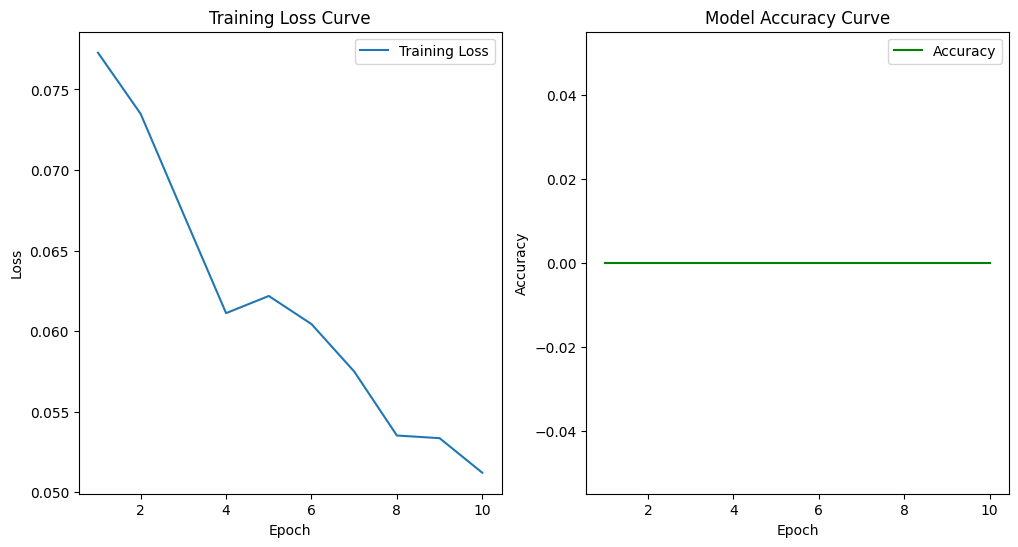

In [27]:
losses, accuracies = train(model, train_loader, test_loader, num_epochs=10)

In [48]:
accuracy = evaluate(model, test_loader, device)

Evaluation Accuracy (IoU > 0.05): 0.00%


In [62]:
print(f'Final Evaluation Accuracy: {accuracy * 100:.2f}%')

Final Evaluation Accuracy: 65.23%


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T

def visualize_predictions(model, data_loader, device, num_samples=3):
    model.eval()
    with torch.no_grad():
        sample_count = 0
        for i, (images, targets) in enumerate(data_loader):

            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get model predictions
            outputs = model(images)

            for j in range(len(images)):
                if sample_count >= num_samples:
                    break

                image = images[j].cpu().numpy().transpose(1, 2, 0)
                image = np.clip(image, 0, 1)

                true_boxes = targets[j]['boxes'].cpu().numpy()
                true_labels = targets[j]['labels'].cpu().numpy()
                pred_boxes = outputs[j]['boxes'].cpu().numpy()
                pred_labels = outputs[j]['labels'].cpu().numpy()


                plt.figure(figsize=(15,15))
                plt.imshow(image)


                for box, label in zip(true_boxes, true_labels):
                    xmin, ymin, xmax, ymax = box
                    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                      edgecolor='red', facecolor='none', linewidth=2))
                    plt.text(xmin, ymin, f'True: {label}', color='red', fontsize=10, verticalalignment='top')


                for box, label in zip(pred_boxes, pred_labels):
                    xmin, ymin, xmax, ymax = box
                    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                                      edgecolor='blue', facecolor='none', linewidth=2))
                    plt.text(xmin, ymin, f'Pred: {label}', color='blue', fontsize=10, verticalalignment='top')

                plt.axis('off')
                plt.show()

                sample_count += 1

            if sample_count >= num_samples:
                break


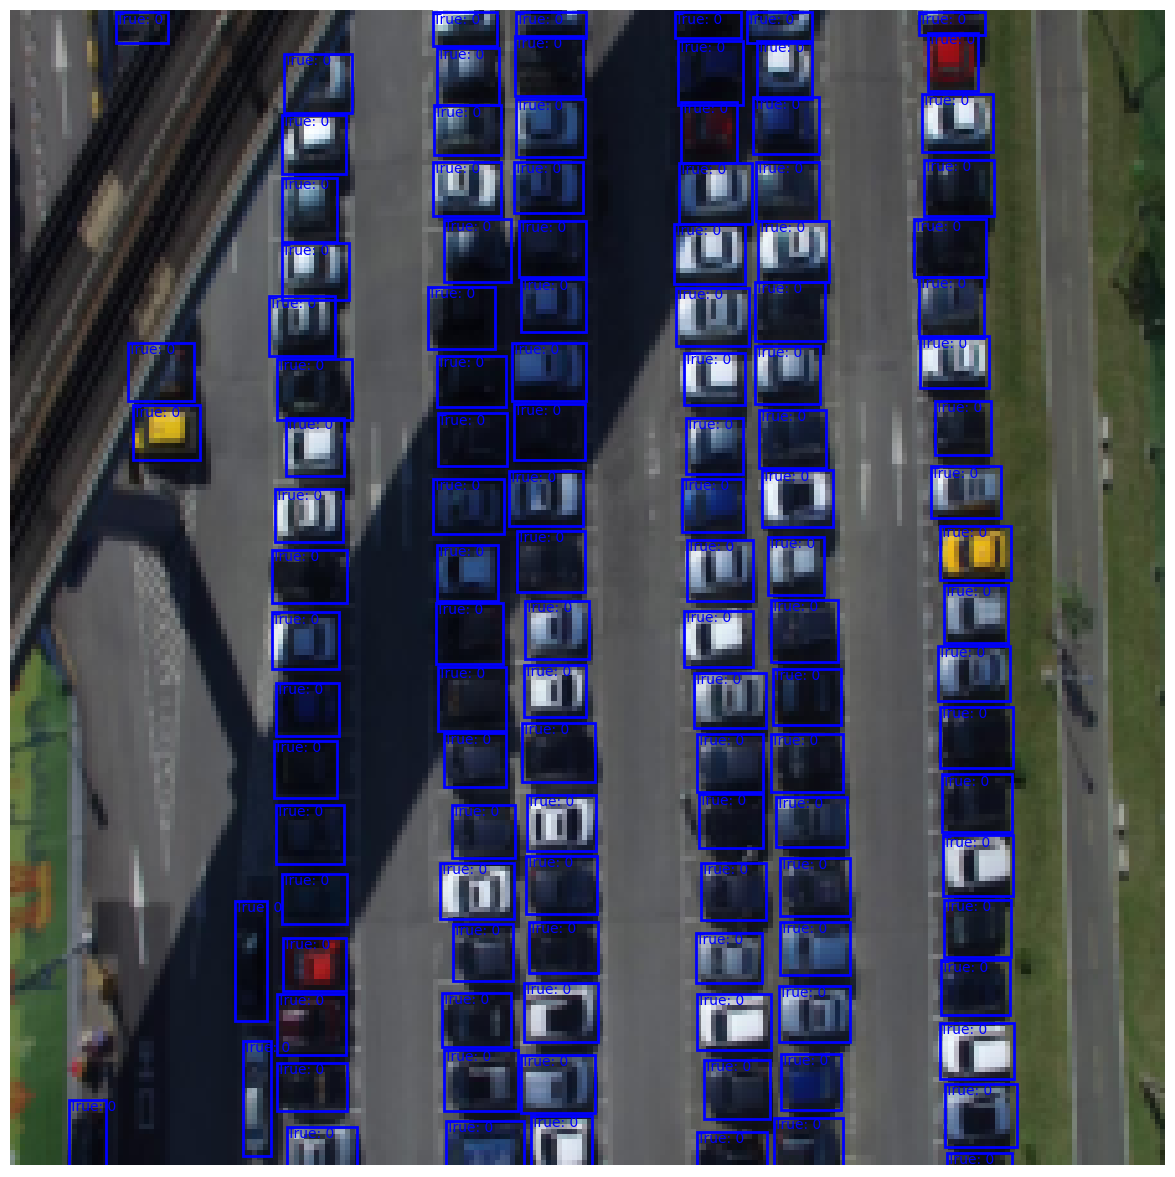

In [70]:
visualize_predictions(model, test_loader, device, num_samples=1)


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # Custom FrozenBatchNorm2d layer
# class FrozenBatchNorm2d(nn.Module):
#     def __init__(self, num_features, eps=1e-5):
#         super(FrozenBatchNorm2d, self).__init__()
#         self.num_features = num_features
#         self.eps = eps
#         self.weight = nn.Parameter(torch.ones(num_features))
#         self.bias = nn.Parameter(torch.zeros(num_features))
#         self.running_mean = torch.zeros(num_features)
#         self.running_var = torch.ones(num_features)

#     def forward(self, x):
#         # Apply BatchNorm
#         return F.batch_norm(x, self.running_mean, self.running_var, self.weight, self.bias, training=False, eps=self.eps)

# # Bottleneck Block (ResNet style)
# class Bottleneck(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(Bottleneck, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
#         self.bn1 = FrozenBatchNorm2d(out_channels)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = FrozenBatchNorm2d(out_channels)
#         self.conv3 = nn.Conv2d(out_channels, out_channels * 4, kernel_size=1, stride=1, bias=False)
#         self.bn3 = FrozenBatchNorm2d(out_channels * 4)
#         self.relu = nn.ReLU(inplace=True)

#         # Downsample layer
#         self.downsample = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels * 4, kernel_size=1, stride=1, bias=False),
#             FrozenBatchNorm2d(out_channels * 4)
#         )

#     def forward(self, x):
#         identity = x
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.relu(self.bn2(self.conv2(out)))
#         out = self.bn3(self.conv3(out))
#         identity = self.downsample(x)
#         out += identity
#         out = self.relu(out)
#         return out

# # Backbone Network
# class BackboneWithFPN(nn.Module):
#     def __init__(self):
#         super(BackboneWithFPN, self).__init__()
#         # Initial layers
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = FrozenBatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         # ResNet layer1 (Bottleneck Blocks)
#         self.layer1 = nn.Sequential(
#             Bottleneck(64, 64),
#             Bottleneck(256, 64),
#             Bottleneck(256, 64)
#         )
#         self.body = nn.ModuleDict({
#             'conv1': self.conv1,
#             'bn1': self.bn1,
#             'relu': self.relu,
#             'maxpool': self.maxpool,
#             'layer1': self.layer1
#         })
#     def forward(self, x):
#         # Forward pass through the network
#         x = self.relu(self.bn1(self.conv1(x)))
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         return x

# # Instantiate and test the model
# model = BackboneWithFPN()

# # Create a random input tensor (batch size of 1, 3 channels, 224x224 image)
# input_tensor = torch.randn(1, 3, 224, 224)

# # Forward pass
# output = model(input_tensor)
# print("Output shape:", output.shape)

# accuracy = evaluate(model, test_loader, device)
# print(f'Final Evaluation Accuracy: {accuracy * 100:.2f}%')
